In [6]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [7]:
def resize_3d_image(x_arr, shape=(256, 256)):
    """ Takes a 3D image (set of 2D images) and downscales each of the images.
        x_arr -- 3D image to be downscaled
        scale -- scale to be achieved. """
    num_arrays = x_arr.shape[2]
    x_new = np.zeros((shape[0], shape[1], num_arrays))
    for i in range(0, num_arrays):
        x_new[:, :, i] = cv2.resize(x_arr[:, :, i], shape)
    return x_new
        

In [3]:
def padding(x_arr, x_pad=np.zeros((256, 256, 1)), num_pad=39):
    """ Concatenates the padding layer num_pad times to the end of x_arr.
        Needed to normalize length of images in the third dimension for
        medical imaging.
        x_arr -- array to be padded in the third dimension
        x_pad -- the pad to be applied (default - 2D matrix of zeros 
        of shape (256, 256))
        num_pad -- the normalized size we want all images to have 
        (default - 39)"""
    layers_to_add = num_pad - x_arr.shape[2]
    if (layers_to_add <= 0):
        return x_arr
    for i in range(0, layers_to_add):
        x_arr = np.concatenate([x_arr, x_pad], axis=2)
    return x_arr


In [4]:
def resize_and_save(range_array=range(1, 202), path_in='data/data/fractals_', path_in_ext='.mat', path_out='data/resized/fractals_', path_out_ext='.npy'):
    """ Does resizing and padding for our set of 3D .mat images and saves them as .npy files.
        Can define a range object range_array to control what objects you want iterated over."""
    for i in range_array:
        X = loadmat(path_in + str(i) + path_in_ext)
        print(i, end=' ')
        X['X'] = padding(resize_3d_image(X['X']))
        np.save(path_out + str(i) + path_out_ext, X)
        del(X)
    return 0

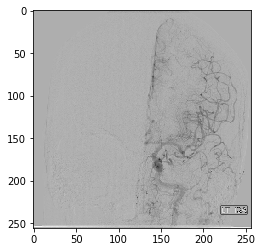

In [5]:
## Accessing the data
X = np.load('data/resized/fractals_25.npy').item()
plt.imshow(X['X'][:, :, 10], cmap='gray')

### Generating an Atlas

In [6]:
# Need to load all the images into RAM and then take the mean of them
# Or, load an image, add it to the existing sum, then delete it.
fractals_path = ['data/resized/fractals_' + str(i) + '.npy' for i in range(1, 202)]
sum_array = np.zeros((256, 256, 39))

def generate_atlas(range_array, sum_array, save=False, length=39, path_out='data/'):
    for i in range_array:
        print(i, end=' ')
        X = np.load(i).item()
        sum_array += X['X']
        del(X)
    atlas = sum_array/length
    if save:
        np.save(path_out + 'atlas.npy', atlas)
    return atlas

atlas = generate_atlas(fractals_path, sum_array, True)

data/resized/fractals_1.npy data/resized/fractals_2.npy data/resized/fractals_3.npy data/resized/fractals_4.npy data/resized/fractals_5.npy data/resized/fractals_6.npy data/resized/fractals_7.npy data/resized/fractals_8.npy data/resized/fractals_9.npy data/resized/fractals_10.npy data/resized/fractals_11.npy data/resized/fractals_12.npy data/resized/fractals_13.npy data/resized/fractals_14.npy data/resized/fractals_15.npy data/resized/fractals_16.npy data/resized/fractals_17.npy data/resized/fractals_18.npy data/resized/fractals_19.npy data/resized/fractals_20.npy data/resized/fractals_21.npy data/resized/fractals_22.npy data/resized/fractals_23.npy data/resized/fractals_24.npy data/resized/fractals_25.npy data/resized/fractals_26.npy data/resized/fractals_27.npy data/resized/fractals_28.npy data/resized/fractals_29.npy data/resized/fractals_30.npy data/resized/fractals_31.npy data/resized/fractals_32.npy data/resized/fractals_33.npy data/resized/fractals_34.npy data/resized/fractals_3

In [7]:
atlas.shape

(256, 256, 39)

In [8]:
import keras

Using TensorFlow backend.


In [9]:
from scipy import signal
X = np.load('data/resized/fractals_1.npy').item()
x_arr = X['X']

In [10]:
signal.fftconvolve(np.arange(0, 9).reshape(3,3), np.eye(3), mode='same')

array([[ 4.,  6.,  2.],
       [10., 12.,  6.],
       [ 6., 10., 12.]])

In [11]:
convolve = signal.fftconvolve(x_arr, atlas, mode='same')

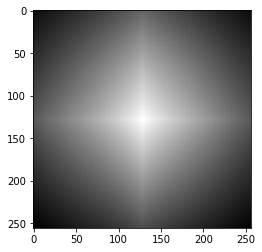

In [12]:
# I don't know what to make of this, it doesn't really give all that much information to be honest
# Data Augmentation has to be the path forward I think.
plt.imshow(convolve[:, :, 38], cmap='gray')

### Data Pre-Processing New Direction - post 5/22/19
Instead of doing zero padding, we're going to take a small sample of each patient's data and generate a mean of that sample. Then, we're going to identify if it is left brain or right brain and crop accordingly to get an image of shape=(512, 256) which will be associated with a single label. Then the models will be trained on those rectangular 2D images.

This was decided with Prof. Scalzo at meeting on 22nd May 2019. 

In [8]:
# Generating mean of a small sample of time slices from the image
# This function will be changed assuming Prof. Scalzo comes through with the formatted data
# Right now it just takes 4 before and 1 after the midpoint
def sample(image, image_shape):
    midpoint = np.ceil(image_shape[2]/2).astype(int)
    image_sample = image[:, :, midpoint - 4: midpoint + 1]
    return np.mean(image_sample, axis=2)

In [24]:
# In this cell I take in a 3D image, sample some slices on the time axis, take the mean and then save the mean
# with the rest of the dictionary as a 
import sys

def save_means(range_array, sample_fn=sample, resize_shape=(512, 512), path_in = 'data/data/fractals_', in_type='.mat', path_out='data/means/fractals_'):
    """ Does resizing and generates sample means for our set of 3D .mat images and saves them as .npy files.
        Can define a range object range_array to control what objects you want iterated over.
        Note - please forgive the horrendous print statement code I just think progress bars are cool."""
    for i in range_array:
        sys.stdout.write('\r')
        sys.stdout.write('[' + np.ceil(i/2).astype(int)*'#' + np.ceil(((range_array[-1] - i)/2) - 1).astype(int)*'.' + ']' + '{0:.2f}'.format(i*100/range_array[-1]) + '%')
        sys.stdout.flush()
        X = loadmat(path_in + str(i) + in_type)
        X['X'] = cv2.resize(sample_fn(X['X'], X['X'].shape), resize_shape)
        np.save(path_out + str(i) + '.npy', X)
        del(X)
    return 0

save_means(range(17, 202))

[#####################################################################################################]100.00%

0

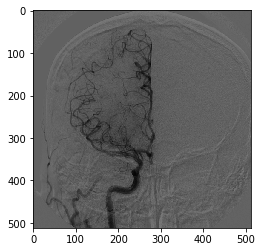

TICI report value:  [[0]]


In [38]:
## Sanity check on data
X = np.load('data/means/fractals_65.npy').item()
plt.imshow(X['X'], cmap='gray')
plt.show()
print("TICI report value: ", X['TICI_report'])